In [64]:
import pandas as pd
import seaborn
import matplotlib
import nltk
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences

In [2]:
# Load data
train_df = pd.read_csv('data/twitter_training.csv', header=None, 
                       names=['tweet_id', 'entity', 'sentiment', 'tweet_content'])
val_df = pd.read_csv('data/twitter_validation.csv', header=None, 
                       names=['tweet_id', 'entity', 'sentiment', 'tweet_content'])

# 1. Data exploration

## train_df

In [3]:
for col in train_df:
    print(col, ':', len(train_df[col].unique()))

tweet_id : 12447
entity : 32
sentiment : 4
tweet_content : 69492


In [4]:
# Drop NAs
print(train_df.isnull().sum(axis=0))
train_df = train_df.dropna(axis=0)

tweet_id           0
entity             0
sentiment          0
tweet_content    686
dtype: int64


In [4]:
# idk what's going on but only take the first of each tweet_id
train_df = train_df.groupby('tweet_id', as_index = True).first()

<AxesSubplot:xlabel='sentiment', ylabel='Count'>

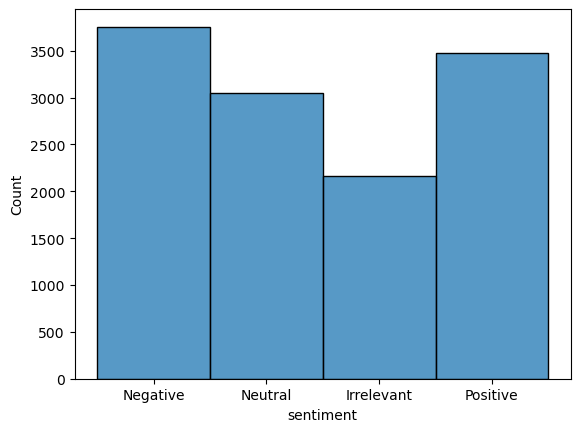

In [5]:
# histplot of sentiment
seaborn.histplot(train_df.sentiment)

## val_df

In [7]:
for col in val_df:
    print(col, ':', len(val_df[col].unique()))

tweet_id : 1000
entity : 32
sentiment : 4
tweet_content : 999


In [8]:
# Drop NAs
print(val_df.isnull().sum(axis=0))

tweet_id         0
entity           0
sentiment        0
tweet_content    0
dtype: int64


<AxesSubplot:xlabel='sentiment', ylabel='Count'>

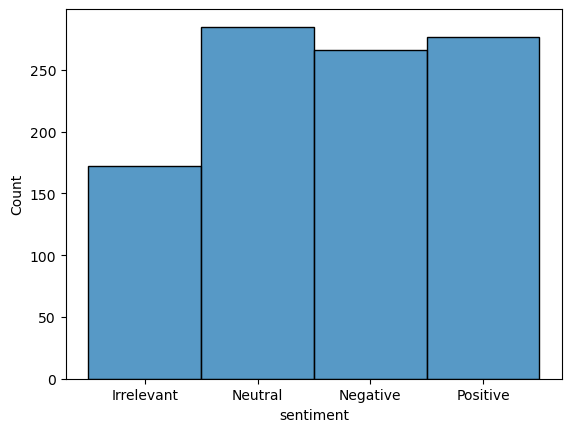

In [9]:
# histplot of sentiment
seaborn.histplot(val_df.sentiment)

# Text Processing
1. Lowercasing
2. Remove all punctuation except for apostrophes
3. Whitespace tokenisation
4. Removing stopwords
5. Removing words with numbers (numbers, usernames etc.)
6. POS tagging
7. Lemmatisation

(find size of vocabulary after processing, one hot encode each tweet for final vocab)

In [ ]:
# dictionary to store all tokens
tweet_dict = {tweet_id: None for tweet_id in train_df.index}

# getting stopwords
stopwords_list = stopwords.words('english')

# POS tagging and lemmatisation
#nltk.download('averaged_perceptron_tagger')  # Download POS tagger data
#nltk.download('wordnet')

In [39]:
# function to convert POS tags to wordnet tags
def convert_pos_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [48]:
# Tokenisation
for tweet_id in tweet_dict.keys():
    tweet = train_df.loc[tweet_id]['tweet_content']
    
    # lowercasing
    tweet = tweet.lower()

    # remove all punctuation except for apostrophes
    tweet = re.sub(r'[^\w\d\s\']+', ' ', tweet)
    
    # whitespace tokenisation
    tweet_tokens = nltk.WhitespaceTokenizer().tokenize(tweet)
    
    # removing stopwords
    tweet_tokens = [word for word in tweet_tokens if word not in stopwords_list]

    # remove any words with numbers in them
    tweet_tokens = [token for token in tweet_tokens if not re.match(r'.*\d.*', token)]

    # POS tagging and convert to wordnet tags
    tagged_tweet_tokens = nltk.pos_tag(tweet_tokens)

    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for token, pos_tag in tagged_tweet_tokens:
        wn_pos = convert_pos_tag(pos_tag)
        if wn_pos is not None:
            lemma = lemmatizer.lemmatize(token, pos=wn_pos)
        else:
            lemma = lemmatizer.lemmatize(token)
        
        lemmas.append(lemma)

    # update dictionary
    tweet_dict[tweet_id] = lemmas

# Embedding layer
With our preprocessed tweets, we one-hot encode each tweet using the Keras one_hot function, then feed into the Embedding layer to obtain the embedding matrix. 

We then train our model using the embeddings.
* Train with our dataset
* Use Keras pre-trained embedding layers

In [56]:
# finding vocabulary size and max tweet size
vocabulary = set()
max_tweet_size = 0
for tokens in tweet_dict.values():
    # vocabulary
    vocabulary.update(tokens)

    # finding max tweet size for padding
    if len(tokens) > max_tweet_size:
        max_tweet_size = len(tokens)

vocab_size = len(vocabulary)
print('Vocabulary size: ', vocab_size)
print('Max tweet size: ', max_tweet_size)

Vocabulary size:  16649
Max tweet size:  43


In [72]:
# one hot encode using Keras
# expand vocab size to increase uniqueness of hashes
for tweet_id, tweet_lemma in tweet_dict.items():
    encoded = [one_hot(token, vocab_size*1.25) for token in tweet_lemma]
    encoded_flat = [enc_token for token in encoded for enc_token in token] # flatten list
    encoded_flat.extend([0]* (max_tweet_size - len(encoded_flat))) # padding
    tweet_dict[tweet_id] = encoded_flat


In [ ]:
# pad each tweet so they are all the same size

# Model Fitting
Using a suitable classification model, we fit our word embeddings into our model to obtain predictions